In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'} or file[-4:] in {'jpeg'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [3]:
data_path = fr'Image'
os.listdir(data_path)

['MonkeyHead',
 '.DS_Store',
 'Natural',
 'BearHead',
 'PigHead',
 'CatHead',
 'MouseHead',
 'WolfHead',
 'HumanHead',
 'PigeonHead',
 'CowHead',
 'SheepHead',
 'ChickenHead',
 'TigerHead',
 'EagleHead',
 'PandaHead',
 'RabbitHead',
 'DogHead',
 'DuckHead',
 'LionHead',
 'ElephantHead',
 'DeerHead']

In [4]:
base_name = 'animal_faces'
width = 80
 
include = {'ChickenHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead', 'WolfHead'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

MonkeyHead
WolfHead
ChickenHead
EagleHead
PandaHead
DeerHead


In [5]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  615
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['Chicken' 'Deer' 'Eagle' 'Monkey' 'Panda' 'Wolf']


Counter({'Monkey': 100,
         'Wolf': 100,
         'Chicken': 100,
         'Eagle': 97,
         'Panda': 117,
         'Deer': 101})

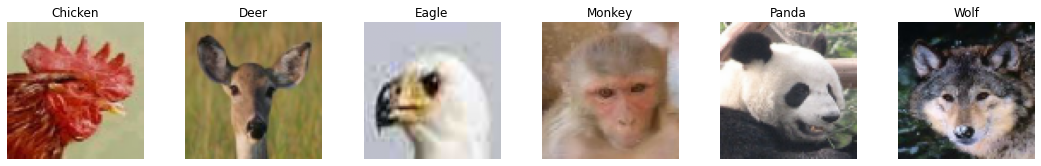

In [6]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [7]:
X = np.array(data['data'])
print(X.shape)
y = np.array(data['label'])
print(y.shape)

(615, 80, 80, 3)
(615,)


In [8]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

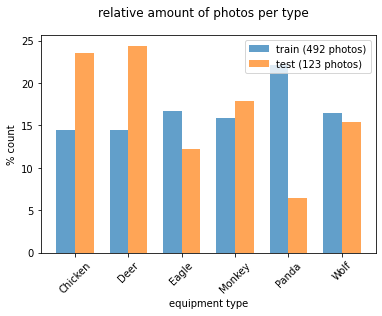

In [9]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

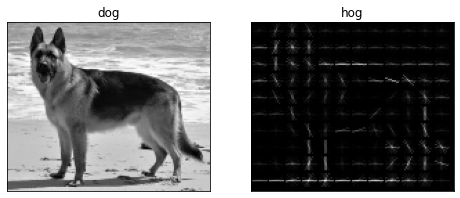

In [10]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('TestFile/TestImages/DogPhotoGerman.jpeg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(12,12), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [11]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])


number of pixels:  17934
number of hog features:  3564


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(16, 16), 
    cells_per_block=(4,4), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)
print(len(X_train_prepared[0]))

(492, 576)
576


In [14]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)


SGDClassifier(random_state=42)

In [15]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [16]:
y_pred = sgd_clf.predict(X_test_prepared)
print(y_pred.shape)
print(y_test.shape)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

(123,)
(123,)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  92.6829268292683


In [17]:
import pandas as pd

In [18]:
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


In [19]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df


prediction,yes,no
label,,
yes,4,2
no,1,3


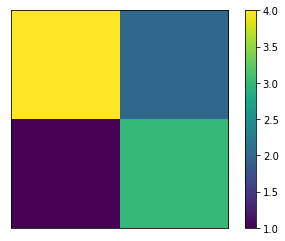

In [20]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

In [21]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[26,  0,  1,  2,  0,  0],
       [ 0, 30,  0,  0,  0,  0],
       [ 0,  1, 14,  0,  0,  0],
       [ 1,  0,  0, 19,  2,  0],
       [ 0,  0,  1,  0,  7,  0],
       [ 0,  0,  0,  0,  1, 18]])


 ['Chicken', 'Deer', 'Eagle', 'Monkey', 'Panda', 'Wolf']


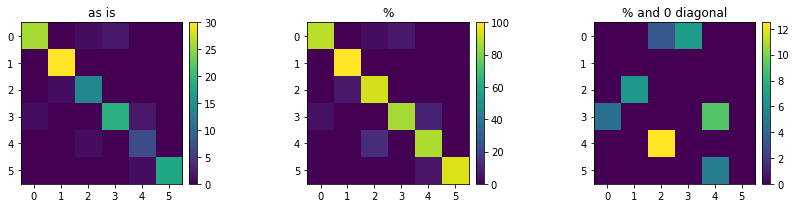

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))


In [23]:
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import datasets
from sklearn import svm


In [24]:
X = np.array(data['data'])
y = np.array(data['label'])
clf = svm.SVC(kernel='linear', C=1)

test_gray = grayify.transform(X)
test_hog = hogify.transform(test_gray)
test_prepared = scalify.transform(test_hog)


In [25]:
# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(clf, test_prepared, y, cv=8)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all 5 folds:
print(scores.mean())

[0.83116883 0.85714286 0.92207792 0.93506494 0.92207792 0.92207792
 0.96103896 0.93421053]
0.9106074846206424


In [26]:

data_path = fr'TestFile'
print(os.listdir(data_path))
base_name = 'germanShep'
width = 80

include = {'wolf'}
resize_all(src=data_path, pklname=base_name, width=width, include=include)


['TestImages', '.DS_Store', 'wolf', '.ipynb_checkpoints']
wolf


In [27]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ')
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  1
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape: 
labels: ['']


Counter({'': 1})

In [28]:
# np.array.reshape(1,-1)
X_real = np.array(data['data'])
X_real.reshape(1,-1)
print(X_real.shape)


actual_gray = grayify.transform(X_real)
actual_hog = hogify.transform(actual_gray)
actual_prepared = scalify.transform(actual_hog)
print(actual_prepared)
y_pred = sgd_clf.predict(actual_prepared)
print(y_pred)


(1, 80, 80, 3)
[[ 1.22351602e+00 -2.96943092e-01 -1.92715471e-01 -5.31064046e-01
   1.42575295e-02  1.31715788e-01 -4.91921263e-02  4.73022217e-01
   3.66817573e+00  1.34937018e+00 -7.72663781e-01 -1.01279591e+00
  -1.16541033e+00 -1.25314263e+00 -1.12546500e+00 -1.04330068e+00
  -7.60599364e-01  2.06840756e+00  4.04991663e-01 -3.22679442e-01
  -6.11348393e-01 -8.78172717e-01 -9.86561234e-01 -5.88094450e-01
   1.72514704e+00  2.82585838e+00  1.19364454e+00  2.02221492e+00
   2.65456576e+00  3.81919680e-01  7.68245692e-01 -6.09800452e-01
  -6.99741720e-01 -5.88878100e-01 -5.28877336e-01  2.75673490e-01
   1.13945582e+00 -7.79656611e-01 -7.98137324e-01 -7.60060950e-01
  -6.21882346e-01 -1.09787129e+00 -8.64680662e-01 -7.04809209e-01
   7.41962746e-01  7.92993834e-01 -1.55455781e+00 -1.67162727e+00
  -1.55972465e+00 -1.37482592e+00 -1.24512668e+00 -8.79128614e-01
  -4.24956217e-01  6.39484058e-01  4.57586720e+00  9.73831504e-01
   2.63210367e-01 -5.06540397e-01 -7.60767777e-01 -1.11279256